In [103]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import mne_connectivity

In [104]:
%matplotlib inline

## Computing frequency-resolved connectivity between signals in a multivariate manner

In [105]:
def simulate_signals(
    n_seeds: int,
    n_targets: int,
    freq_band: tuple[int, int],
    n_epochs: int = 10,
    n_times: int = 200,
    sfreq: int = 100,
    snr: float = 0.7,
    connection_delay: int = 10,
    rng_seed: int | None = None,
) -> mne.Epochs:
    """Simulates signals interacting in a given frequency band.

    Parameters
    ----------
    n_seeds : int
        Number of seed channels to simulate.

    n_targets : int
        Number of target channels to simulate.

    freq_band : tuple of int, int
        Frequency band where the connectivity should be simulated, where the
        first entry corresponds to the lower frequency, and the second entry to
        the higher frequency.

    n_epochs : int (default 10)
        Number of epochs in the simulated data.

    n_times : int (default 200)
        Number of timepoints each epoch of the simulated data.

    sfreq : int (default 100)
        Sampling frequency of the simulated data, in Hz.

    snr : float (default 0.7)
        Signal-to-noise ratio of the simulated data.

    connection_delay : int (default 10)
        Number of timepoints for the delay of connectivity between the seeds
        and targets. If > 0, the target data is a delayed form of the seed
        data by this many timepoints.

    rng_seed : int | None (default None)
        Seed to use for the random number generator. If `None`, no seed is
        specified.

    Returns
    -------
    epochs : mne.Epochs
        The simulated data stored in an Epochs object. The channels are
        arranged according to seeds, then targets.
    """
    if rng_seed is not None:
        np.random.seed(rng_seed)

    n_channels = n_seeds + n_targets
    trans_bandwidth = 1  # Hz

    # simulate signal source at desired frequency band
    signal = np.random.randn(1, n_epochs * n_times + connection_delay)
    signal = mne.filter.filter_data(
        data=signal,
        sfreq=sfreq,
        l_freq=freq_band[0],
        h_freq=freq_band[1],
        l_trans_bandwidth=trans_bandwidth,
        h_trans_bandwidth=trans_bandwidth,
        fir_design="firwin2",
        verbose=False,
    )

    # simulate noise for each channel
    noise = np.random.randn(n_channels, n_epochs * n_times + connection_delay)

    # create data by projecting signal into noise
    data = (signal * snr) + (noise * (1 - snr))

    # shift target data by desired delay
    if connection_delay > 0:
        # shift target data
        data[n_seeds:, connection_delay:] = data[
            n_seeds:, : n_epochs * n_times
        ]
        # remove extra time
        data = data[:, : n_epochs * n_times]

    # reshape data into epochs
    data = data.reshape(n_channels, n_epochs, n_times)
    data = data.transpose((1, 0, 2))  # (epochs x channels x times)

    # store data in an MNE Epochs object
    ch_names = [
        f"{ch_i}_{freq_band[0]}_{freq_band[1]}" for ch_i in range(n_channels)
    ]
    info = mne.create_info(
        ch_names=ch_names, sfreq=sfreq, ch_types="eeg", verbose=False
    )
    epochs = mne.EpochsArray(data=data, info=info, verbose=False)

    return epochs

In [106]:
def plot_connectivity(results: np.ndarray, freqs: list):
    """Plots connectivity results for a single connection.
    
    Parameters
    ----------
    results : numpy.ndarray, shape of (frequencies)
        Results for a single connection.
    
    freqs : list
        Frequencies in `results`.
    """
    if results.shape != (len(freqs), ):
        raise ValueError(
            "`results` must be a 1D array with the same length as `freqs`."
        )
    fig, ax = plt.subplots(1, 1)
    ax.plot(freqs, results, linewidth=3)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Connectivity (A.U.)")
    plt.show()

### Part 1 - Simulating connectivity

As before, use the `simulate_signals` function to generate some data which we can explore multivariate connectivity computations on.

**Exercises - simulating connectivity**

1a) Simulate two interacting channels in the frequency range: 5-10 Hz; 15-20 Hz; and 25-30 Hz.

In [107]:
epochs_5_10 = simulate_signals(n_seeds=1, n_targets=1, freq_band=(5, 10))
epochs_15_20 = simulate_signals(n_seeds=1, n_targets=1, freq_band=(15, 20))
epochs_25_30 = simulate_signals(n_seeds=1, n_targets=1, freq_band=(25, 30))

1b) Combine the three sets of `Epochs` into a single `Epochs` object.

In [108]:
epochs = epochs_5_10.copy().add_channels([epochs_15_20, epochs_25_30])

1c) Verify that activity is present in the appropriate frequency ranges.

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\tsbin\AppData\Local\Temp\ipykernel_17380\487507482.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.compute_psd().plot();
c:\Users\tsbin\anaconda3\envs\mne_course\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


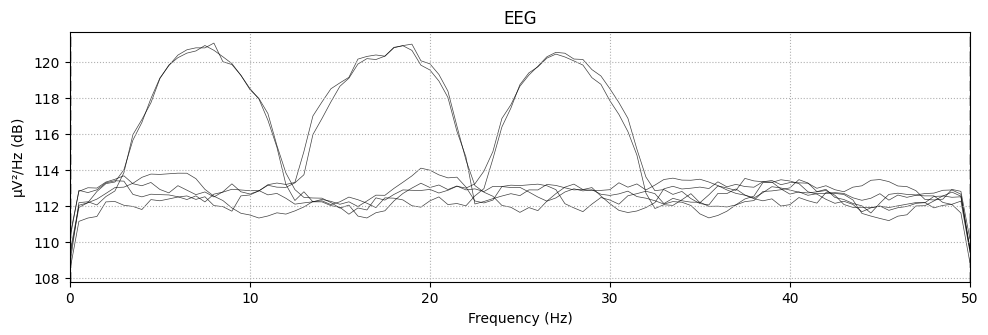

In [109]:
epochs.compute_psd().plot();

### Part 2 - A recap of bivariate connectivity

Again, we will use `mne_connectivity.spectral_connectivity_epochs` to compute connectivity between the simulated signals, and will first generate the results from a bivariate connectivity method to use as a comparison for the multivariate methods.

**Exercises - bivariate connectivity**

2a) Compute connectivity using the imaginary part of coherency (`imcoh` method), specifying the indices to only compute connections between the three sets of interacting channels.

In [110]:
bivariate_connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="imcoh", indices=([0, 2, 4], [1, 3, 5]))

Connectivity computation...
    computing connectivity for 3 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
[Connectivity computation done]


C:\Users\tsbin\AppData\Local\Temp\ipykernel_17380\3663887950.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  bivariate_connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="imcoh", indices=([0, 2, 4], [1, 3, 5]))


2b) Plot the connectivity results for each connection to verify the interaction is present.

*Hint:* Results for the imaginary part of coherency can be positive and negative, however for our purposes, taking the absolute values of the results will be sufficient.

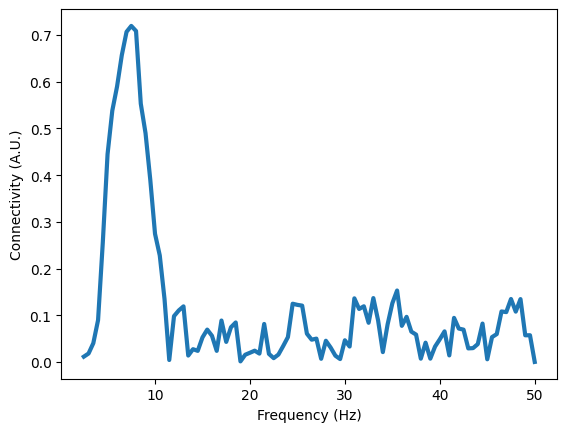

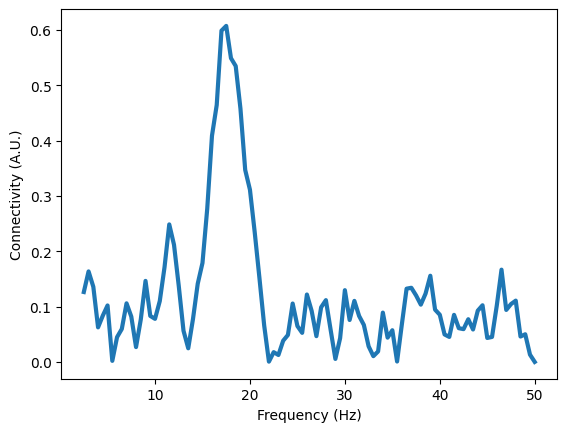

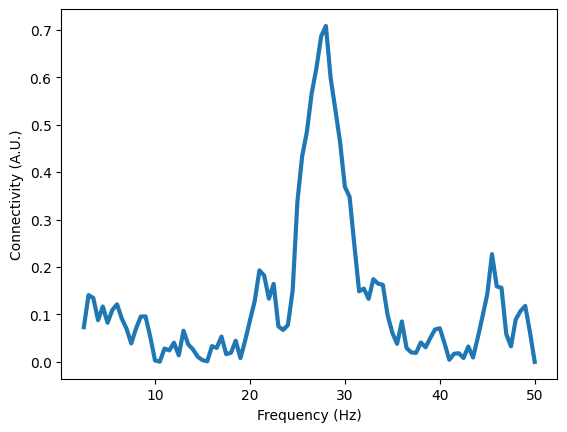

In [111]:
for con_idx in range(len(bivariate_connectivity.indices[0])):
    plot_connectivity(np.abs(bivariate_connectivity.get_data()[con_idx]), bivariate_connectivity.freqs)

2c) Now summarise the results by averaging across the three connections.

In [112]:
average_connectivity = np.mean(np.abs(bivariate_connectivity.get_data()), axis=0)

2c) Plot the average bivariate connectivity results. What do you notice?

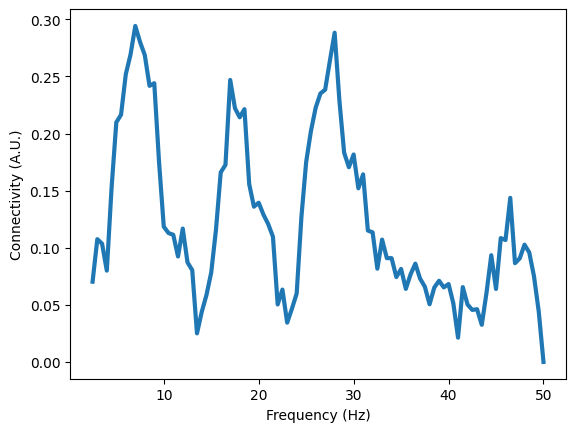

In [113]:
plot_connectivity(average_connectivity, bivariate_connectivity.freqs)

### Part 3 - Multivariate connectivity

We will now examine connectivity for some multivariate methods, but before we do so, we need to consider the `indices` parameter again.

`indices` has the form `(seeds, targets)`, where the length of `seeds` and `targets` corresponds to the number of connections.

For bivariate connectivity `seeds` and `targets` are array-likes of integers, e.g. `seeds=[0, 2, 4]` and `targets=[1, 3, 5]`.

For multivariate connectivity on the other hand, since we are computing connectivity between multiple channels, we need a way to distinguish between the channels belonging to each connection. Accordingly, we nest the entries for each connection as array-likes within `seeds` and `targets`.

E.g. computing a single multivariate connection between channels 0, 2, and 4 to channels 1, 3, and 5 would require `seeds=[[0, 2, 4]]` and `targets=[[1, 3, 5]]`.<br>
Note how the length of `seeds` and `targets` still corresponds to the number of connections (in this case, one).

E.g. we could compute two multivariate connections with `seeds=[[0], [2, 4]]` and `targets=[[1, 3], [5]]`.<br>
Again, the lengths of `seeds` and `targets` correspond to the number of connections (two), but see how we specify the channels for each connections as a separate array-like.<br>
You may also notice that the number of channels can differ for each connection, making these multivariate methods very flexible.

More information on the `indices` parameter for multivariate connectivity can be found here: https://mne.tools/mne-connectivity/dev/auto_examples/handling_ragged_arrays.html#sphx-glr-auto-examples-handling-ragged-arrays-py

**Exercises - multivariate connectivity**

3a) Compute connectivity using the equivalent multivariate method (maximised imaginary part of coherency; `mic` method) for each connection separately (i.e. three connections in total).

In [114]:
multivariate_connectivity_separate = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="mic", indices=([[0], [2], [4]], [[1], [3], [5]]))

Connectivity computation...
    computing connectivity for 3 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (1)
    connection 2 - seeds (1); targets (1)
    connection 3 - seeds (1); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: MIC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing MIC for connection 1 of 3


C:\Users\tsbin\AppData\Local\Temp\ipykernel_17380\2671753179.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  multivariate_connectivity_separate = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="mic", indices=([[0], [2], [4]], [[1], [3], [5]]))
100%|██████████| frequency blocks : 96/96 [00:00<00:00, 5289.51it/s]

Computing MIC for connection 2 of 3



100%|██████████| frequency blocks : 96/96 [00:00<00:00, 6189.14it/s]

Computing MIC for connection 3 of 3



100%|██████████| frequency blocks : 96/96 [00:00<00:00, 8005.19it/s]

[Connectivity computation done]


3b) Now plot the results for each connection. How do they compare to the results for bivariate connectivity?

*Hint:* We again want to take the absolute values of the results.

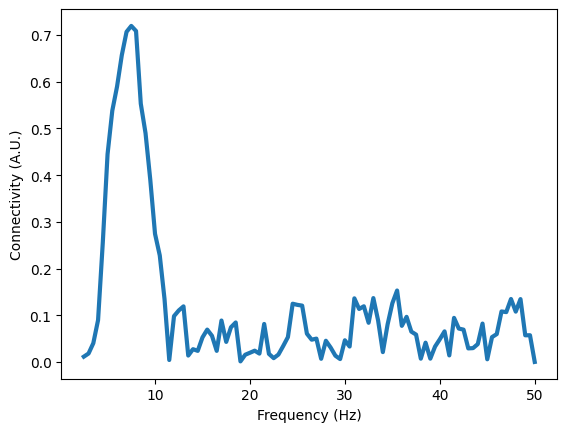

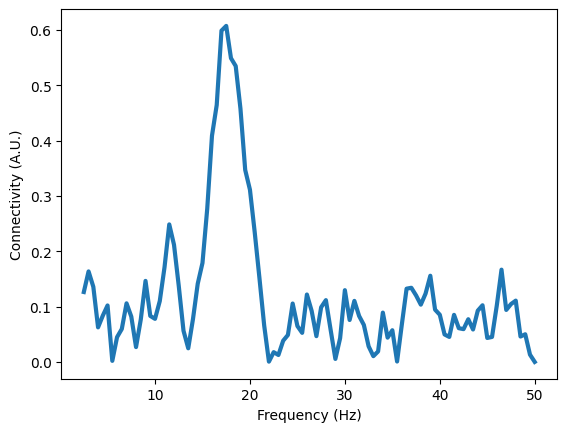

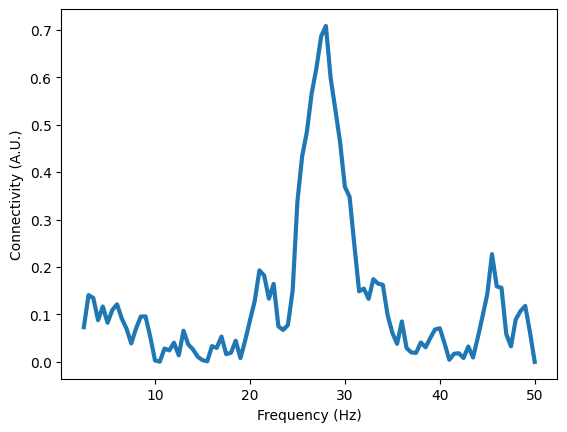

In [115]:
for con_idx in range(len(multivariate_connectivity_separate.indices[0])):
    plot_connectivity(np.abs(multivariate_connectivity_separate.get_data()[con_idx]), multivariate_connectivity_separate.freqs)

3c) Now compute connectivity between the same seed and target channels as before but in a single connection.

In [116]:
multivariate_connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="mic", indices=([[0, 2, 4]], [[1, 3, 5]]))

Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
Estimated data ranks:
    connection 1 - seeds (3); targets (3)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: MIC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing MIC for connection 1 of 1


C:\Users\tsbin\AppData\Local\Temp\ipykernel_17380\443428879.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  multivariate_connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="mic", indices=([[0, 2, 4]], [[1, 3, 5]]))
100%|██████████| frequency blocks : 96/96 [00:00<00:00,  230.54it/s]

[Connectivity computation done]


3d) Plot the results for this single connection. How does it compare to the averaged results of the bivariate connectivity?

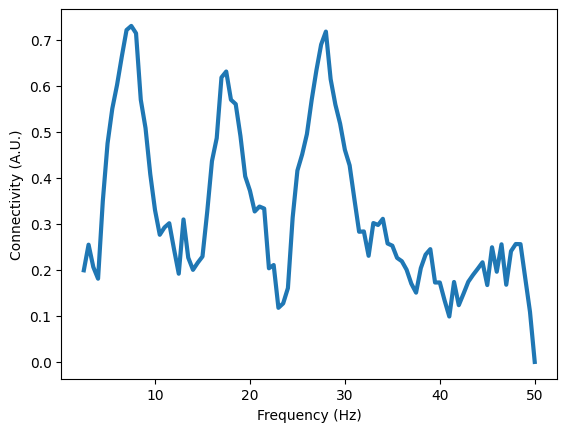

In [117]:
plot_connectivity(np.abs(multivariate_connectivity.get_data()[0]), multivariate_connectivity.freqs)

### Part 4 - Directed connectivity

So far, the focus has been on coherency-based measures of connectivity. The measures can be very powerful, but they tell us nothing about the direction of the interaction between signals (i.e. they are undirected measures of connectivity).

In contrast, directed measures of connectivity tell us how information is flowing between seeds and targets. Several directed measures exist, but here we will look at Granger causality (a multivariate version of which is available in MNE).

When we created the signals, we simulated the information flow from the seeds to the targets, and so we expect Granger causality to be high from `seeds -> targets`, but low from `targets -> seeds`.

**Exercises - directed connectivity**

4a) Compute Granger causality (`gc` method) from the seeds to the targets as a single connection and plot the results.

Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
Estimated data ranks:
    connection 1 - seeds (3); targets (3)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1


C:\Users\tsbin\AppData\Local\Temp\ipykernel_17380\1128973086.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_seeds_targets = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="gc", indices=([[0, 2, 4]], [[1, 3, 5]]))


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 96/96 [00:15<00:00,    6.16it/s]

[Connectivity computation done]


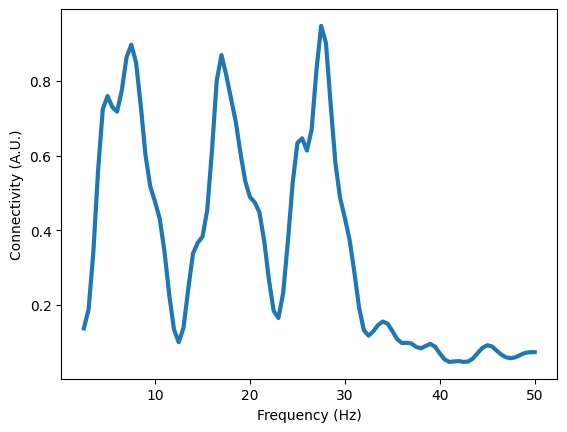

In [118]:
gc_seeds_targets = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="gc", indices=([[0, 2, 4]], [[1, 3, 5]]))
plot_connectivity(gc_seeds_targets.get_data()[0], gc_seeds_targets.freqs)

4b) Now compute Granger causality from the targets to the seeds as a single connection and plot the results.

Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
Estimated data ranks:
    connection 1 - seeds (3); targets (3)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


C:\Users\tsbin\AppData\Local\Temp\ipykernel_17380\974881667.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_targets_seeds = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="gc", indices=([[1, 3, 5]], [[0, 2, 4]]))
100%|██████████| frequency blocks : 96/96 [00:08<00:00,   10.74it/s]

[Connectivity computation done]


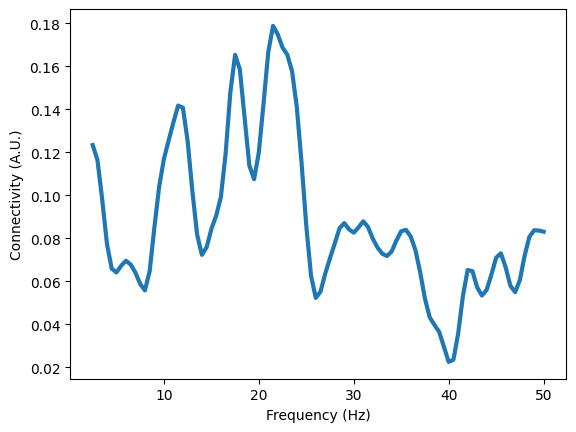

In [119]:
gc_targets_seeds = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="gc", indices=([[1, 3, 5]], [[0, 2, 4]]))
plot_connectivity(gc_targets_seeds.get_data()[0], gc_targets_seeds.freqs)

4c) Both directions of connectivity can also be computed in the same function call. Try this now, and plot the results to verify they match those when computed separately. Do the results align with our expectations?

Connectivity computation...
    computing connectivity for 2 connections
    using t=0.000s..1.990s for estimation (200 points)


C:\Users\tsbin\AppData\Local\Temp\ipykernel_17380\2754685544.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  gc = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="gc", indices=([[0, 2, 4], [1, 3, 5]], [[1, 3, 5], [0, 2, 4]]))


    frequencies: 2.5Hz..50.0Hz (96 points)
Estimated data ranks:
    connection 1 - seeds (3); targets (3)
    connection 2 - seeds (3); targets (3)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 2


100%|██████████| frequency blocks : 96/96 [00:03<00:00,   25.14it/s]

Computing GC for connection 2 of 2



100%|██████████| frequency blocks : 96/96 [00:02<00:00,   36.93it/s]

[Connectivity computation done]


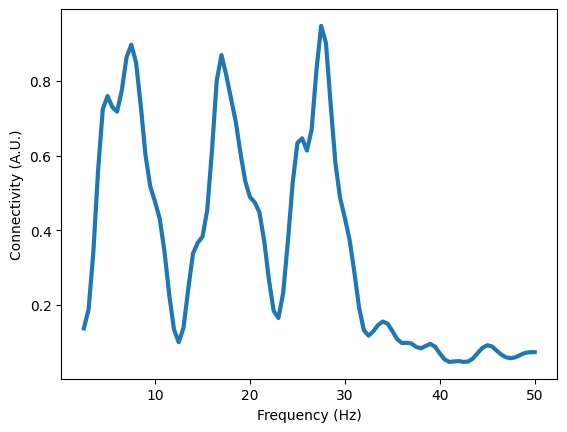

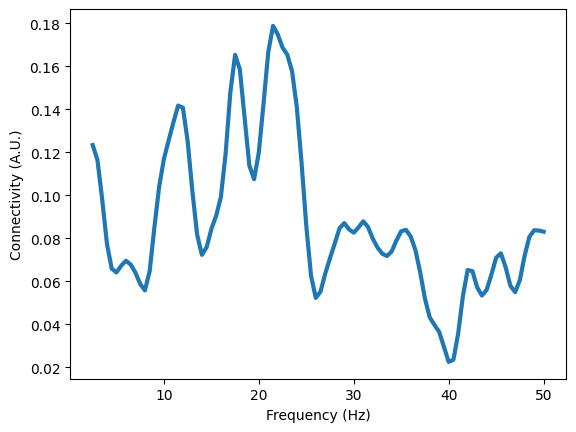

In [120]:
gc = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="gc", indices=([[0, 2, 4], [1, 3, 5]], [[1, 3, 5], [0, 2, 4]]))

for con_idx in range(2):
    plot_connectivity(gc.get_data()[con_idx], gc.freqs)

It is often the case that we study systems of bidirectional information flow. Accordingly, examining the **net** directionality of communication can be very useful in identifying the 'drivers' and 'recipients'.

Net Granger causality can be easily computed by subtracting the results from one another: `seeds -> targets` - `targets -> seeds`.

4d) Compute the net Granger scores and plot the results. What does this tell us about which set of signals are the 'drivers' and which are the 'recipients'?

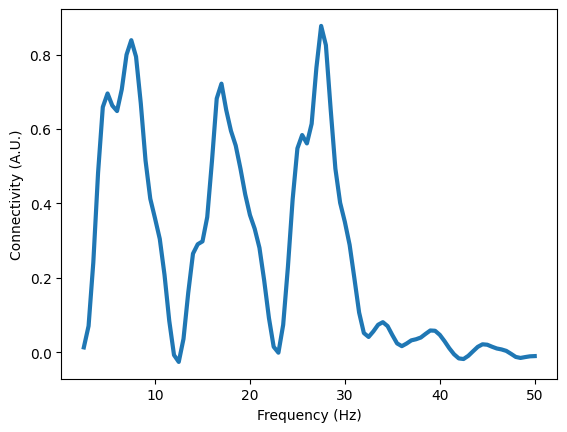

In [121]:
plot_connectivity(gc.get_data()[0] - gc.get_data()[1], gc_seeds_targets.freqs)

4e) Check what happens if we flip the seeds and targets when computing the net Granger scores. Does this tell us the same thing?

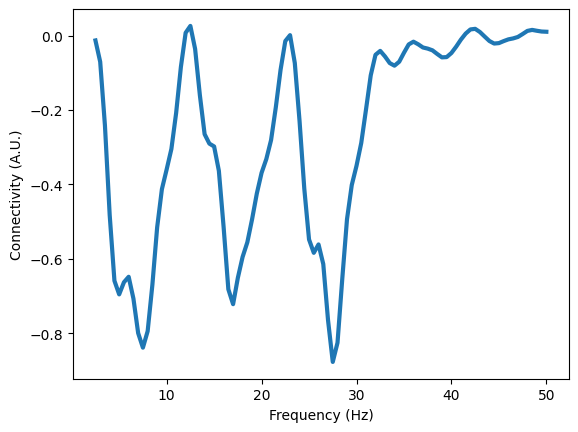

In [122]:
plot_connectivity(gc.get_data()[1] - gc.get_data()[0], gc_seeds_targets.freqs)

The examples above have been kept simple to demonstrate the basic principles of multivariate connectivity in MNE. The extensive benefits of multivariate connectivity methods are realised fully in scenarios involving a large number of channels with complex interactions, scenarios where data-driven approaches for extracting the relevant components of connectivity are extremely powerful.

Further information on how multivariate connectivity methods can be used and applied to more complex data scenarios can be found in the following examples:
- Multivariate coherency: https://mne.tools/mne-connectivity/dev/auto_examples/mic_mim.html
- Multivariate Granger causality: https://mne.tools/mne-connectivity/dev/auto_examples/granger_causality.html